In [17]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from math import sqrt
from datetime import datetime

from core.data.file_processing import open_all_data, inferred_land_sink, all_dgvms_gl
from core.data.data_processing import trend
from core.modeling import WindowGenerator, lstm_model, compile_and_fit, Baseline, linear_model

# Import data 

In [2]:
df = open_all_data()
df_no_na = df.dropna()
df_no_na.index = pd.to_datetime(df_no_na.index).to_period("M")
df_iav = trend(df_no_na)

df_inf = inferred_land_sink()
df_inf = df_inf.dropna()
df_inf['Inferred_land_sink'] = df_inf['GL_ff_emissions'] \
                             + df_inf['LUC'] \
                             - df_inf['monthly_gr'] \
                             + df_inf['ocean_sink_GL'] # because already negative
df_inf['Inferred_land_sink'] = -1 * df_inf['Inferred_land_sink']
df_inf['Emission_flux'] = df_inf['GL_ff_emissions'] + df_inf['LUC']

df_inf_iav = trend(df_inf)

In [3]:
df_iav_select = df_iav[['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR', 'ENSO']]
df_inf_select = df_inf_iav[['Inferred_land_sink', 'Emission_flux']]

In [4]:
df_all = df_iav_select[1:].merge(df_inf_select, left_index=True, right_index=True)
df_all

,land_sink_GL,Landtemp_GL,Landtemp_TR,Pre_GL,Pre_TR,ENSO,Inferred_land_sink,Emission_flux
time,,,,,,,,
1980-02,0.092564,-0.283749,0.449947,67.260871,91.321893,0.5,-0.362497,0.555734
1980-03,0.086849,-0.241958,0.427786,67.368384,91.484640,0.3,-0.345074,0.554174
1980-04,0.081135,-0.200168,0.405626,67.475897,91.647387,0.4,-0.327651,0.552614
1980-05,0.075420,-0.158377,0.383465,67.583410,91.810135,0.5,-0.310229,0.551055
1980-06,0.069705,-0.116586,0.361305,67.690923,91.972882,0.5,-0.292806,0.549495
...,...,...,...,...,...,...,...,...
2019-08,-0.115516,1.163805,0.914567,69.557906,93.454402,0.1,-0.368421,0.972241
2019-09,-0.112590,1.176326,0.927641,69.428300,93.438218,0.2,-0.338518,0.974102
2019-10,-0.109141,1.189851,0.934879,69.458855,93.631625,0.3,-0.315865,0.975956


<AxesSubplot:xlabel='time'>

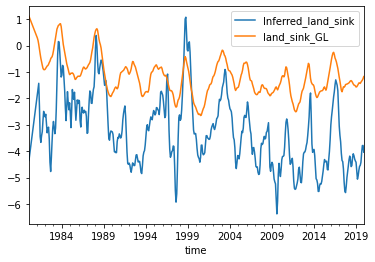

In [5]:
(12*df_all[['Inferred_land_sink', 'land_sink_GL']]).plot()

In [6]:
dgvms = trend(all_dgvms_gl('core/data/').dropna())

In [7]:
df_all = df_all.merge(dgvms, left_index=True, right_index=True)

In [8]:
# Inferred land sink uncertainty
unc = pd.read_csv('core/data/Inferred_land_sink_unc.csv', index_col=0)
unc = unc.set_index(pd.to_datetime(unc.index, format="%Y-%m")).to_period("M")

# Prepare data

In [9]:
df = df_all.copy()
df.columns

Index(['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR',
       'ENSO', 'Inferred_land_sink', 'Emission_flux', 'CLM5.0', 'IBIS', 'ISAM',
       'ISBA-CTRIP', 'JSBACH', 'JULES-ES', 'LPJ', 'LPX-Bern', 'OCN',
       'ORCHIDEEv3', 'SDGVM', 'VISIT', 'YIBs'],
      dtype='object')

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
test_df_pure = df[int(n*0.9):]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Correlations

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'ILS'),
  Text(0, 1.5, 'TEMP_GL'),
  Text(0, 2.5, 'TEMP_TR'),
  Text(0, 3.5, 'PRE_GL'),
  Text(0, 4.5, 'PRE_TR'),
  Text(0, 5.5, 'ENSO'),
  Text(0, 6.5, 'FF_LUC')])

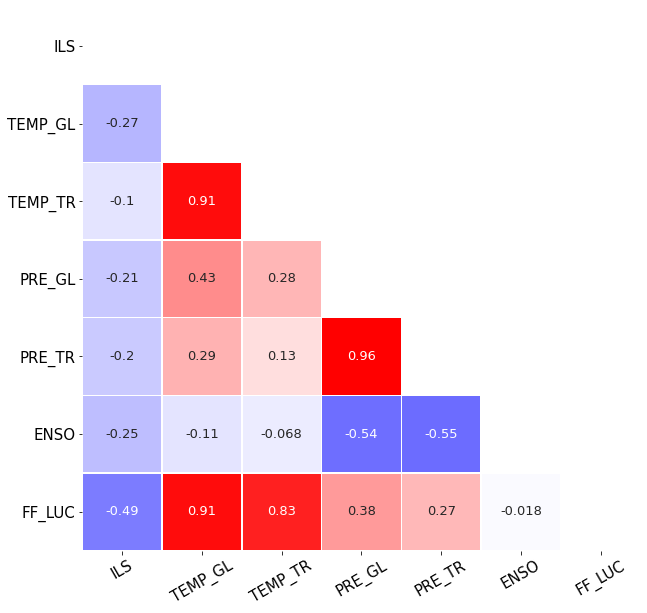

In [16]:
df_all_corr = df_all[['Inferred_land_sink', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR', 'ENSO', 'Emission_flux']]
df_all_corr = df_all_corr.rename(columns={"Landtemp_GL": "TEMP_GL", "Landtemp_TR": "TEMP_TR", 'Pre_GL': 'PRE_GL', 'Pre_TR': 'PRE_TR', 'Inferred_land_sink': 'ILS', 'Emission_flux': 'FF_LUC'})
corr = df_all_corr.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

plt.figure(figsize=(10,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, cbar=False, cmap="bwr", linewidths=.5, center=0, annot_kws={"size": 13})

plt.xticks(rotation=30, size=15)
plt.yticks(rotation=0, size=15)

# Run Trials

In [18]:
MAX_EPOCHS = 50
dependent_variable = 'Inferred_land_sink'

# Track the best overall model
best_model = None
best_MAE = 1000000000
best_model_name = ""

# Set up DF to store training/testing info across all tests
columns = ['Val loss', 'Val MAE', 'Test loss', 'Test MAE', 'Best Epoch',
           'Num_Batches', 'Batch_Size_data', 'Timestep',
           'Batch_size_train', 'Dependent', 'Variables', 'Name', 'Model Number', 'Time']
eval_df = pd.DataFrame(columns=columns)
predictions_df = pd.DataFrame(index=test_df.index[1:])

### Choose independent variable sets

In [70]:
independent_variable_sets = [
    ['Emission_flux', 'Landtemp_TR', 'Landtemp_GL', 'Pre_GL', 'Pre_TR', 'ENSO'],
    [],
]

In [71]:
experiment_number = 0
dependent_variable = "Inferred_land_sink"

for independent_variables in independent_variable_sets:

    # Select data
    variables = [dependent_variable] + independent_variables
    train_df_use = train_df[variables]
    val_df_use = val_df[variables]
    test_df_use = test_df[variables]

    TIMESTEP_LENGTH = 6
    DATA_BATCH_SIZE = 10

    experiment_number = experiment_number + 1

    # Create window for training (data partition)
    wide_window = WindowGenerator(
            input_width=TIMESTEP_LENGTH, label_width=TIMESTEP_LENGTH, shift=1,
            train_df=train_df_use, val_df=val_df_use, test_df=test_df_use,
            sequence_stride=1, batch_size=DATA_BATCH_SIZE,
            label_columns=[dependent_variable])

    # Set up window for taking all predictions
    test_window = WindowGenerator(
            input_width=len(test_df_use)-1, label_width=len(test_df_use)-1, shift=1,
            train_df=train_df_use, val_df=val_df_use, test_df=test_df_use,
            sequence_stride=1, batch_size=20,
            label_columns=[dependent_variable])
    inputs, labels = next(iter(test_window.test))
    label_col_index = test_window.label_columns_indices.get(dependent_variable, None)

    for i in range(10):

        start=datetime.now()
        model_name = f'model_{experiment_number}_run_{i}'
        print(f"Running Model {model_name}")
        curr_lstm = lstm_model() # change here to baseline or linear

        history = compile_and_fit(curr_lstm, wide_window, max_epochs=MAX_EPOCHS)

        stopped_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
        val_performance = curr_lstm.evaluate(wide_window.val, verbose=0)
        performance = curr_lstm.evaluate(wide_window.test, verbose=0)

        df_vals = {'Val loss': val_performance[0],
                   'Val MAE': val_performance[1],
                   'Test loss': performance[0],
                   'Test MAE': performance[1],
                   'Best Epoch': stopped_epoch,
                   'Num_Batches': len(wide_window.train),
                   'Batch_Size_data': wide_window.batch_size,
                   'Timestep': wide_window.input_width,
                   'Batch_size_train': 'NA',
                   'Dependent': dependent_variable,
                   'Variables': independent_variables,
                   'Name': model_name,
                   'Model Number': experiment_number,
                   'Time': (datetime.now()-start)}

        eval_df = eval_df.append(df_vals, ignore_index=True)

        predictions = curr_lstm(inputs)
        predictions_df[model_name] = curr_lstm(inputs)[0, :, label_col_index]

        if performance[1] < best_MAE:
            best_MAE = performance[1]
            best_model = curr_lstm
            best_model_name = model_name

Running Model model_1_run_0
Running Model model_1_run_1
Running Model model_1_run_2
Running Model model_1_run_3
Running Model model_1_run_4
Running Model model_1_run_5
Running Model model_1_run_6
Running Model model_1_run_7
Running Model model_1_run_8
Running Model model_1_run_9


In [59]:
eval_df.groupby('Model Number').mean()

,Val loss,Val MAE,Test loss,Test MAE
Model Number,,,,
1,0.343715,0.415699,0.340225,0.366273


### Save output data

In [68]:
RUN_NAME = "LSTM_multi"

predictions_df.to_csv(f'RUNS/predictions_{RUN_NAME}.csv')
eval_df.to_csv(f'RUNS/eval_{RUN_NAME}.csv')
eval_df.groupby('Model Number').std().to_csv(f'RUNS/eval_std_{RUN_NAME}.csv')
eval_df.groupby('Model Number').mean().to_csv(f'RUNS/eval_mean_{RUN_NAME}.csv')

### Plot results

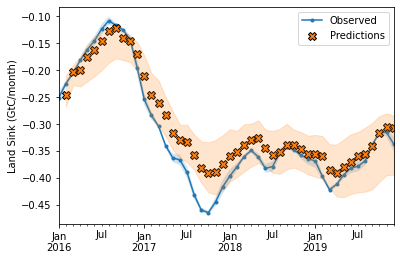

In [67]:
errors = unc.join(test_df[dependent_variable], how='right')

# Choose if I'm plotting train, val, or test:
to_plot = test_df

# Get the predictions of just the chosen model:
predictions_df_use = predictions_df[[col for col in predictions_df if col.startswith('model_1')]]
#predictions_df_use = predictions_df

# Unnormalize the datasets:
to_plot_gtc = to_plot * train_std + train_mean
predictions_df_gtc = predictions_df_use * train_std[dependent_variable] + train_mean[dependent_variable]

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=-10, xlabel="", ylabel="Land Sink (GtC/month)")

# Plot errors for actual:
errors = unc.join(to_plot_gtc[dependent_variable], how='right')
lower_error_inf = errors[dependent_variable] - errors['unc']
upper_error_inf = errors[dependent_variable] + errors['unc']
plt.fill_between(to_plot_gtc[dependent_variable].index, lower_error_inf, upper_error_inf, alpha=0.2)

# Plot the predicted values of the best model:
plt.scatter(to_plot_gtc.index[1:], predictions_df_gtc[best_model_name],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

# Plot min to max as error bars for the models:
lower_error = predictions_df_gtc.min(axis=1).values
upper_error = predictions_df_gtc.max(axis=1).values
plt.fill_between(to_plot_gtc.index[1:], lower_error, upper_error, alpha=0.2, color='#ff7f0e')

plt.legend()

### Plot from sheet

In [270]:
sheet = pd.read_csv('RUNS/predictions_testing_timestep.csv', index_col=0)

model_2_run_9
model_6_run_1
model_10_run_8
model_14_run_7
model_18_run_9
model_22_run_4
model_26_run_5


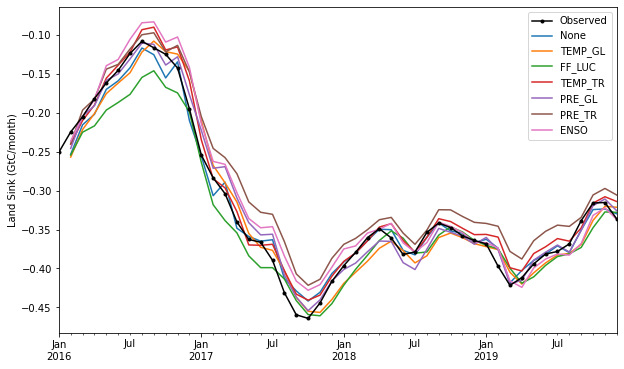

In [299]:
plt.figure(figsize=(10,6))
# Choose if I'm plotting train, val, or test:
to_plot_gtc = test_df_pure

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=10, xlabel="", ylabel="Land Sink (GtC/month)", c='black')




actual = test_df[dependent_variable][1:]
sheet_gtc = sheet * train_std[dependent_variable] + train_mean[dependent_variable]

names = {2: 'None', 6: 'TEMP_GL', 10: 'FF_LUC', 14: 'TEMP_TR', 18: 'PRE_GL', 22: 'PRE_TR', 26: 'ENSO'}

for i in [2, 6, 10, 14, 18, 22, 26]:
    best_error = 10
    best = model_name_to_plot
    for j in range(10):
        model_name_to_plot = 'model_{}_run_{}'.format(i, j)
        predicted = sheet[model_name_to_plot]
        error = mean_absolute_error(actual, predicted)
        if error < best_error:
            best_error = error
            best = model_name_to_plot
    
    # Plot the predicted values of the best model:
    plt.plot(to_plot_gtc.index[1:], sheet_gtc[model_name_to_plot],
            label=names[i])

    print(best)

# Plot the actual values:


    
plt.legend()